# Bayes Rule

Bayes' rule arises when you want to make statements about an unknown quantity (e.g., a parameter, hypothesis, or event) given everything you know about a specific situation (data, and generative model for the data) so you can **condition on all the knowns and treat the unknown as distributions**, scaled by the overall likelihood of data to calibrate.

# Graphical Summary

![Fig](./graphical_summary/slides/Slide23.png)

# Key Formula

$$
P(\theta|D) = \frac{P(D|\theta) × P(\theta)} {P(D)}
$$

- $P(\theta|D)$ is the posterior (probability of parameter $\theta$ given data $D$)
- $P(D|\theta)$ is the likelihood (probability of observing data $D$ given parameter $\theta$)
- $P(\theta)$ is the prior (initial belief about parameter $\theta$)
- $P(D)$ is the evidence/marginal likelihood (total probability of observing data $D$)

# Technical Details

- Interpretation:
  - Bayes’ Rule allows learning from data by adjusting prior beliefs with evidence
  - Posterior probabilities quantify uncertainty about hypotheses or parameters conditioned on all known information
  - Unlike frequentist approaches, Bayesian inference treats parameters as random variables with probability distributions, enabling direct probabilistic statements about parameters
- Applications in statistical genetics:
  - Inferring the probability that a genetic variant affects a trait given observed data
  - Incorporating prior biological knowledge (e.g., functional annotations) in association studies
  - Performing fine-mapping to prioritize causal variants among many candidates

# Related Topics

- [ordinary least squares](https://statfungen.github.io/statgen-primer/ordinary_least_squares.html)
- [summary statistics](https://statfungen.github.io/statgen-primer/summary_statistics.html)
- [likelihood](https://statfungen.github.io/statgen-primer/likelihood.html)

# Example

In our previous likelihood analysis, we found that among our three theories about genetic effects ($\beta = 0$, $\beta = 0.5$, $\beta = 1.0$), the data supported $\beta = 0.5$ most strongly. But this raises a new question: What if we had some prior beliefs about which theory was more plausible before seeing the data?

For example, maybe from previous studies, we thought large genetic effects ($\beta = 1.0$) were rare, while small or no effects were more common. How do we **combine our prior knowledge with what the data tells us to get a final, updated belief**?

This is exactly what Bayes' rule does - it gives us a formal way to update our beliefs based on new evidence. We start with prior probabilities about each theory, multiply by the likelihood (which we already calculated), and get posterior probabilities that represent our updated beliefs after seeing the data.

(Here for simplicity we are still working with the three separate models, but the same thing applies when we consider $\beta$ comes from a distribution, which is exactly what we did in [Lecture: Bayes factor](https://statfungen.github.io/statgen-primer/Bayes_factor.html).)

## Model Setup

In [1]:
# Clear the environment
rm(list = ls())
set.seed(19)  # For reproducibility

# Generate genotype data for 5 individuals at 1 variant
N <- 5
genotypes <- c("CC", "CT", "TT", "CT", "CC")  # Individual genotypes
names(genotypes) <- paste("Individual", 1:N)

# Define alternative allele
alt_allele <- "T"

# Convert to additive genotype coding (count of alternative alleles)
Xraw_additive <- numeric(N)
for (i in 1:N) {
  alleles <- strsplit(genotypes[i], "")[[1]]
  Xraw_additive[i] <- sum(alleles == alt_allele)
}
names(Xraw_additive) <- names(genotypes)

# Standardize genotypes
X <- scale(Xraw_additive, center = TRUE, scale = TRUE)[,1]

In [2]:
# Set true beta and generate phenotype data
true_beta <- 0.4
true_sd <- 1.0

# Generate phenotype with true effect
Y <- X * true_beta + rnorm(N, 0, true_sd)

In [3]:
# Likelihood function for normal distribution
likelihood <- function(beta, sd, X, Y) {
  # Calculate expected values under the model
  mu <- X * beta
  
  # Calculate likelihood (product of normal densities)
  prod(dnorm(Y, mean = mu, sd = sd, log = FALSE))
}

# Log-likelihood function (more numerically stable)
log_likelihood <- function(beta, sd, X, Y) {
  # Calculate expected values under the model
  mu <- X * beta
  
  # Calculate log-likelihood (sum of log normal densities)
  sum(dnorm(Y, mean = mu, sd = sd, log = TRUE))
}


In [4]:
# Test three different models with different beta values
beta_values <- c(0, 0.5, 1.0)  # Three different effect sizes to test
model_names <- paste0("Model ", 1:3, "(beta = ", beta_values, ")")

# Calculate likelihoods and log-likelihoods
results <- data.frame(
  Model = model_names,
  Beta = beta_values,
  Likelihood = numeric(3),
  Log_Likelihood = numeric(3)
)

for (i in 1:3) {
  results$Likelihood[i] <- likelihood(beta = beta_values[i], sd = true_sd, X = X, Y = Y)
  results$Log_Likelihood[i] <- log_likelihood(beta = beta_values[i], sd = true_sd, X = X, Y = Y)
}

In [5]:
results

Model,Beta,Likelihood,Log_Likelihood
<chr>,<dbl>,<dbl>,<dbl>
Model 1(beta = 0),0.0,0.0019210299,-6.254894
Model 2(beta = 0.5),0.5,0.0021961524,-6.121048
Model 3(beta = 1),1.0,0.0009236263,-6.987203


## Setting Prior Beliefs

Now let's specify our prior beliefs about each model. Suppose based on the pQTL analysis results, we have the following prior belief about the models:

In [6]:
# Prior probabilities (must sum to 1)
priors <- c(0.35, 0.35, 0.3)

## Applying Bayes' Rule

In [7]:
# Extract likelihood values from our previous analysis
likelihoods <- results$Likelihood

# Calculate the evidence P(D) = sum of (likelihood × prior) for all models
evidence <- sum(likelihoods * priors)

names(priors) <- c("beta=0", "beta=0.5", "beta=1.0")

# Calculate posterior for each model using Bayes' rule
posteriors <- (likelihoods * priors) / evidence
names(posteriors) <- c("beta=0", "beta=0.5", "beta=1.0")

# Create summary table
bayes_table <- data.frame(
  Model = c("beta=0", "beta=0.5", "beta=1.0"),
  Prior = priors,
  Likelihood = likelihoods,
  Posterior = posteriors
)


The prior, likelihood and posterior for each model is:

In [8]:
bayes_table

,Model,Prior,Likelihood,Posterior
,<chr>,<dbl>,<dbl>,<dbl>
beta=0,beta=0,0.35,0.0019210299,0.3913392
beta=0.5,beta=0.5,0.35,0.0021961524,0.4473852
beta=1.0,beta=1.0,0.30,0.0009236263,0.1612756


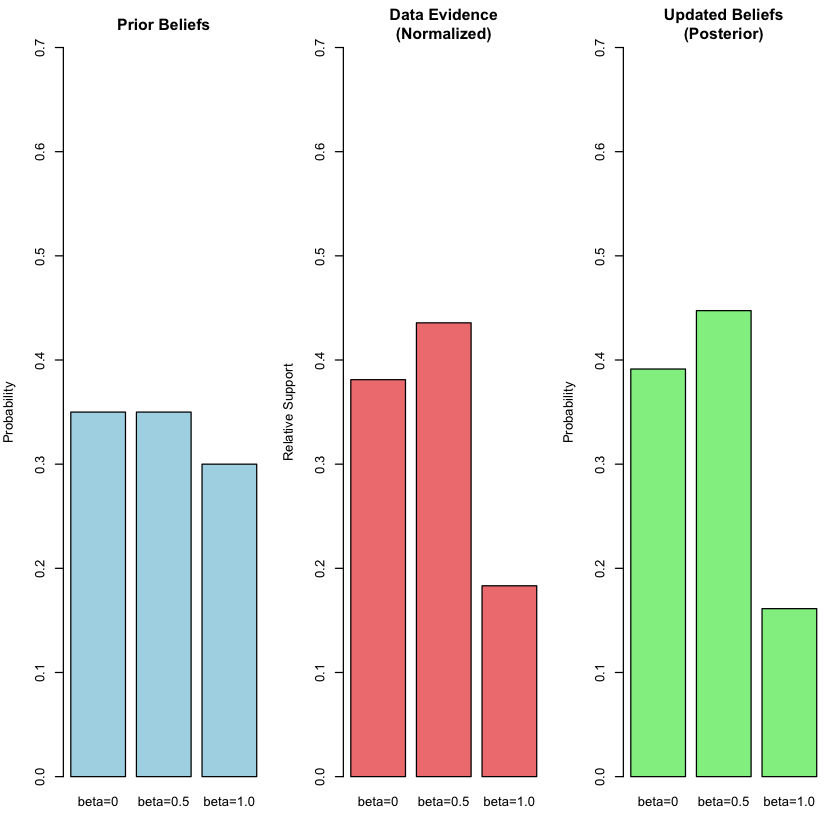

In [9]:
par(mfrow = c(1, 3), mar = c(4, 4, 3, 1))

# Plot 1: Prior beliefs
barplot(priors, main = "Prior Beliefs", ylab = "Probability",
        col = "lightblue", ylim = c(0, 0.7))

# Plot 2: Normalized likelihoods (for visual comparison)
norm_likelihood <- likelihoods / sum(likelihoods)
names(norm_likelihood) <- c("beta=0", "beta=0.5", "beta=1.0")

barplot(norm_likelihood, main = "Data Evidence\n(Normalized)", ylab = "Relative Support",
        col = "lightcoral", ylim = c(0, 0.7))

# Plot 3: Posterior beliefs
barplot(posteriors, main = "Updated Beliefs\n(Posterior)", ylab = "Probability",
        col = "lightgreen", ylim = c(0, 0.7))

par(mfrow = c(1, 1))

The beauty of Bayes' rule is that it provides a principled way to incorporate both prior knowledge and new evidence. Our final belief (posterior) balances what we thought before seeing the data with what the evidence tells us.

# Supplementary
## Graphical Summary


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




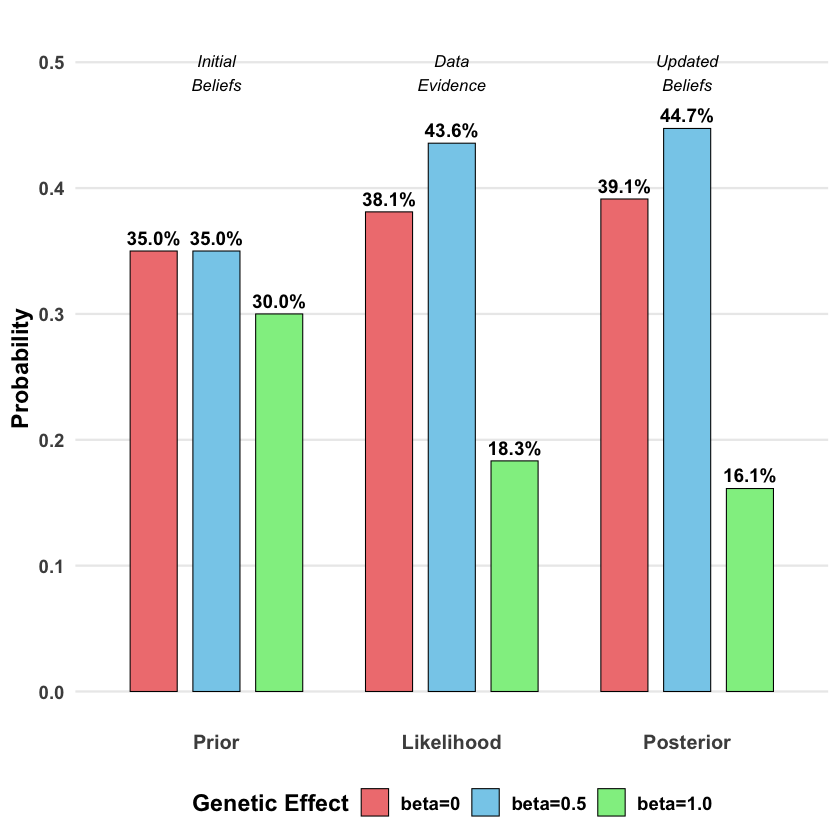

In [10]:
# Beautiful ggplot2 visualization for Bayes rule
library(ggplot2)
library(dplyr)

# Prepare data for ggplot - we need to reshape our results
df_bayes <- data.frame(
  Model = rep(c("beta=0", "beta=0.5", "beta=1.0"), each = 3),
  Stage = rep(c("Prior", "Likelihood", "Posterior"), times = 3),
  Probability = c(
    # beta=0: prior, likelihood, posterior
    priors[1], likelihoods[1]/sum(likelihoods), posteriors[1],
    # beta=0.5: prior, likelihood, posterior  
    priors[2], likelihoods[2]/sum(likelihoods), posteriors[2],
    # beta=1.0: prior, likelihood, posterior
    priors[3], likelihoods[3]/sum(likelihoods), posteriors[3]
  )
)

# Set factor levels for proper ordering
df_bayes$Stage <- factor(df_bayes$Stage, levels = c("Prior", "Likelihood", "Posterior"))
df_bayes$Model <- factor(df_bayes$Model, levels = c("beta=0", "beta=0.5", "beta=1.0"))

# Create the beautiful plot
p_bayes <- ggplot(df_bayes, aes(x = Stage, y = Probability, fill = Model)) +
  geom_col(position = position_dodge(width = 0.8), width = 0.6, 
           color = "black", linewidth = 0.3) +
  geom_text(aes(label = scales::percent(Probability, accuracy = 0.1)), 
            position = position_dodge(width = 0.8), vjust = -0.5, 
            size = 4, fontface = "bold") +
  scale_fill_manual(values = c("lightcoral", "skyblue", "lightgreen"),
                    name = "Genetic Effect") +
  labs(
    y = "Probability",
    x = NULL,
    title = "Bayesian Update: From Prior Beliefs to Posterior Knowledge"
  ) +
  ylim(0, max(df_bayes$Probability) * 1.15) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_blank(),
    axis.title.y = element_text(face = "bold"),
    axis.text.x = element_text(face = "bold", size = 12),
    axis.text.y = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(face = "bold"),
    legend.position = "bottom",
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank()
  ) +
  annotate("text", x = 1, y = max(df_bayes$Probability) * 1.1, 
           label = "Initial\nBeliefs", fontface = "italic", size = 3.5) +
  annotate("text", x = 2, y = max(df_bayes$Probability) * 1.1, 
           label = "Data\nEvidence", fontface = "italic", size = 3.5) +
  annotate("text", x = 3, y = max(df_bayes$Probability) * 1.1, 
           label = "Updated\nBeliefs", fontface = "italic", size = 3.5)

# Display the plot
print(p_bayes)


# Save plot to file
ggsave("./cartoons/Bayes_rule.png", plot = p_bayes,
       width = 10, height = 6, 
       bg = "transparent",
       dpi = 300)